# Financial Document Analyzer: Step-by-Step Demo

This notebook walks you through the full workflow of the **Financial Document Analyzer**, a tool designed to extract, classify, and analyze expenses from financial documents (e.g., "nota integrativa"). The focus is on energy-related expenses and their impact on total service and production costs across different sectors.

### Project Structure
- **`scripts/`**: Contains modular Python scripts for data loading, HTML parsing, expense classification, frequency filtering, and analysis.
- **`data/`**: Holds sample or synthetic financial data.
- **`outputs/`**: Stores generated visualizations.

### Notebook Overview
1. **Load Data**: Start with synthetic or real financial data.
2. **Extract Tables**: Parse HTML to extract expense descriptions and values.
3. **Filter Low-Quality Cost Voices**: Use document frequency to retain only high-quality, standardized expense descriptions.
4. **Filter Expenses Based on Frequency**: Refine the extracted expenses to include only frequent terms.
5. **Classify Expenses**: Use zero-shot NLP with manually defined cost classes to categorize expenses.
6. **Analyze Energy Costs**: Calculate energy expenses and their ratios to service and production costs.
7. **Visualize Trends**: Generate sector-based visualizations.

Let’s get started!

## Step 1: Load Data
We begin by loading financial data into a DataFrame. For this demo, we’ll generate synthetic data on the fly. In a real-world scenario, you can replace this with your own CSV file from the `data/` directory.

In [1]:
import sys
sys.path.append('../scripts')  # Add scripts directory to path

from data_loader import load_data

# Load synthetic data (or specify a file path to load real data)
df = load_data()

# Display the first few rows
print("Sample DataFrame:")
display(df.head())

Sample DataFrame:


,Company_ID,Sector_Code,HTML,Total_Production_Costs,Service_Costs
0,Company_1,Construction,<table><tr><td>Raw Materials</td><td>27339</td...,3767180,528756
1,Company_2,Services,<table><tr><td>Insurance Costs</td><td>7350</t...,3546146,890586
2,Company_3,Manufacturing,<table><tr><td>Legal Services</td><td>6136</td...,501369,527011
3,Company_4,Manufacturing,<table><tr><td>Training Costs</td><td>3633</td...,1170120,317248
4,Company_5,Retail,<table><tr><td>Production Supplies</td><td>267...,1416252,733727


**Explanation**
- **`load_data()`**: This function (from `scripts/data_loader.py`) generates synthetic data with columns like `Company_ID`, `Sector_Code`, `HTML` (containing expense tables), `Total_Production_Costs`, and `Service_Costs`.
- **Output**: A pandas DataFrame with sample financial data for multiple companies.

## Step 2: Extract Tables from HTML
Next, we parse the HTML content in the `HTML` column to extract expense descriptions and their corresponding values.

In [2]:
from html_parser import extract_tables

# Extract expenses from the HTML column
df['Expenses'] = df['HTML'].apply(extract_tables)

# Display extracted expenses for the first company
print("\nExtracted Expenses for Company_1:")
display(df['Expenses'].iloc[0])


Extracted Expenses for Company_1:


[('Raw Materials', 27339.0),
 ('Accounting Services', 10177.0),
 ('Inventory Purchases', 34070.0),
 ('Travel Expenses', 2883.0),
 ('IT Support', 28625.0),
 ('IT Support', 7869.0),
 ('Raw Materials', 24774.0),
 ('Accounting Services', 28409.0),
 ('Raw Materials', 72146.0),
 ('Gas Expenses', 5866.0)]

**Explanation**
- **`extract_tables(html)`**: This function (from `scripts/html_parser.py`) uses BeautifulSoup to parse HTML `<table>` elements, extracting rows (`<tr>`) and cells (`<td>`) into a list of tuples: `(description, value)`.
- **Output**: For each company, a list of expense items.

## Step 3: Filter Low-Quality Cost Voices Using Document Frequency
The extraction method can include irrelevant or low-quality descriptions. To address this, we apply an unsupervised filtering step to retain only high-quality, standardized expense descriptions ("cost voices") that appear frequently across companies.

**Approach**: We calculate the **document frequency** of each description (i.e., the number of companies that mention it) and keep only those that appear in at least a certain percentage of documents (e.g., 10%). This ensures we focus on common, standardized terms while discarding noise.

In [3]:
from frequency_filter import calculate_document_frequency, get_frequent_terms

# Step 3.1: Extract descriptions for frequency analysis
df['Descriptions'] = df['Expenses'].apply(lambda exps: [desc for desc, _ in exps])

# Step 3.2: Calculate document frequency for each description
term_df, total_documents = calculate_document_frequency(df)

# Step 3.3: Get frequent terms (descriptions that appear in at least 10% of documents)
frequent_terms = get_frequent_terms(term_df, total_documents, min_freq=0.1)

frequent_terms

['Inventory Purchases',
 'IT Support',
 'Raw Materials',
 'Accounting Services',
 'Travel Expenses',
 'Gas Expenses',
 'Insurance Costs',
 'Electricity Costs',
 'Power Supply',
 'Consulting Fees',
 'Energy Consumption',
 'Miscellaneous Expenses',
 'Maintenance Services',
 'Legal Services',
 'Training Costs',
 'Construction Materials',
 'Production Supplies',
 'Heating Expenses',
 'Electric Utilities',
 'Packaging Materials',
 'Marketing Expenses',
 'Office Supplies',
 'Fuel Costs']

**Explanation**
- **Extracting Descriptions**: After extracting expenses, we isolate the descriptions to prepare them for frequency analysis. This step aligns with the goal of identifying recurring cost voices across documents.
- **Document Frequency**: The number of companies (documents) in which each expense description appears is calculated to assess its commonality.
- **Filtering**: We retain only descriptions that appear in at least 10% of the companies, ensuring they are standardized and relevant, while filtering out less common or noisy terms.
- **Output**: A list of frequent, high-quality expense descriptions.

## Step 4: Knowledge Engineering
We now have a list of cost voices that have (relatively) high frequency and are also quite clean. We can manually inspect these and come up with our own lexicon of cost voice classes.

Normally, you would have somebody with some domain knowledge define these classes for you. In this case i'll use just my common sense and sets a list of categories after going through the list showed above.

In [4]:
from expense_classifier import classify_expense

candidate_labels = ["Energy", "Services", "Materials", "Other"]

Device set to use mps:0


## Step 5: Classify Expenses Using NLP and Manual Cost Classes
We use zero-shot classification to categorize each filtered expense into predefined cost classes. These classes are manually defined based on domain knowledge to ensure meaningful categorization.

In [15]:
from expense_classifier import classify_expense
import pandas as pd

# Classify each filtered expense using the manual cost classes
df['Classified_Expenses'] = df['Expenses'].apply(
    lambda exps: [(classify_expense(desc, candidate_labels=candidate_labels), value) for desc, value in exps]
)

# Display classified expenses for the first company and compare them against the original description
expenses = df['Expenses'].iloc[0]
classified = df['Classified_Expenses'].iloc[0]

# Create a comparison table
comparison_df = pd.DataFrame(
    [(desc, label) for (desc, _), (label, _) in zip(expenses, classified)],
    columns=['Original Description', 'Classified Label']
)

# Display the table
print("\nComparison for Company_1:")
display(comparison_df)


Comparison for Company_1:


,Original Description,Classified Label
0,Raw Materials,Materials
1,Accounting Services,Services
2,Inventory Purchases,Other
3,Travel Expenses,Other
4,IT Support,Services
5,IT Support,Services
6,Raw Materials,Materials
7,Accounting Services,Services
8,Raw Materials,Materials
9,Gas Expenses,Energy


**Explanation**
- **`classify_expense(desc, candidate_labels)`**: This function (from `scripts/expense_classifier.py`) uses a pre-trained zero-shot classification model to predict the most likely category from the manually defined `cost_classes`.
- **Output**: A list of tuples with classified categories and values, leveraging domain-specific categories for accurate analysis.

## Step 6: Analyze Energy-Related Expenses
Now, we calculate the total energy costs for each company and compute their ratios to service and production costs.

In [6]:
from analysis import analyze_energy_costs

# Perform analysis for each company
df['Analysis'] = df.apply(
    lambda row: analyze_energy_costs(row['Classified_Expenses'], 
                                     row['Service_Costs'], 
                                     row['Total_Production_Costs']), 
    axis=1
)

# Display analysis for the first company
print("\nEnergy Cost Analysis for Company_1:")
display(df['Analysis'])


Energy Cost Analysis for Company_1:


0    {'Energy_Costs': 5866.0, 'Energy_to_Service_Ra...
1    {'Energy_Costs': 113689.0, 'Energy_to_Service_...
2    {'Energy_Costs': 31402.0, 'Energy_to_Service_R...
3    {'Energy_Costs': 0, 'Energy_to_Service_Ratio':...
4    {'Energy_Costs': 110346.0, 'Energy_to_Service_...
5    {'Energy_Costs': 41496.0, 'Energy_to_Service_R...
6    {'Energy_Costs': 63764.0, 'Energy_to_Service_R...
7    {'Energy_Costs': 76030.0, 'Energy_to_Service_R...
8    {'Energy_Costs': 48841.0, 'Energy_to_Service_R...
9    {'Energy_Costs': 123379.0, 'Energy_to_Service_...
Name: Analysis, dtype: object

**Explanation**
- **`analyze_energy_costs(classified_expenses, service_costs, production_costs)`**: This function (from `scripts/analysis.py`) does the following:
  1. Sums all expenses classified as "energia" to get `Energy_Costs`.
  2. Calculates `Energy_to_Service_Ratio` = `Energy_Costs / Service_Costs`.
  3. Calculates `Energy_to_Production_Ratio` = `Energy_Costs / Total_Production_Costs`.
- **Output**: A dictionary with analysis results.

## Step 7: Visualize Sector Trends
Finally, we aggregate the energy cost ratios by sector and create bar charts to visualize trends.

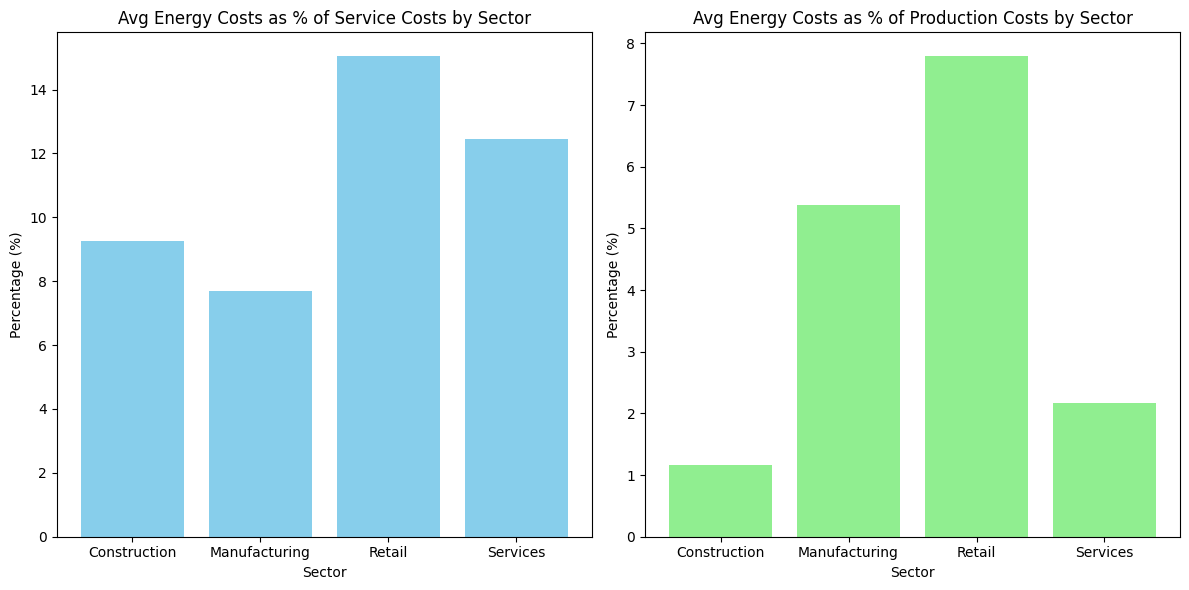

In [7]:
from analysis import plot_sector_analysis

# Generate and display the plots
plot_sector_analysis(df)

**Explanation**
- **`plot_sector_analysis(df)`**: This function (from `scripts/analysis.py`) performs the following:
  1. Groups the DataFrame by `Sector_Code`.
  2. Calculates the mean `Energy_to_Service_Ratio` and `Energy_to_Production_Ratio` for each sector.
  3. Creates two bar charts:
     - **Chart 1**: Average energy costs as a percentage of service costs by sector.
     - **Chart 2**: Average energy costs as a percentage of production costs by sector.
- **Output**: Visualizations saved to `outputs/sector_energy_analysis.png`.

## Conclusion
This notebook demonstrates how to:
- **Extract structured data** from unstructured HTML financial documents.
- **Filter low-quality data** using document frequency to ensure reliability.
- **Apply NLP** for zero-shot classification with domain-specific cost classes.
- **Perform financial analysis** to understand energy cost impacts.
- **Visualize insights** across sectors using bar charts.

### Next Steps
You can extend this project by:
- Loading real data from the `data/` directory instead of synthetic data.
- Fine-tuning the zero-shot classification model with domain-specific examples.
- Adding interactive visualizations using tools like Streamlit or Plotly.
- Testing out newer models

Happy analyzing!